In [1]:
import numpy as np
import tensorflow as tf
import spektral
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network

In [2]:
cora = spektral.datasets.citation.Citation("Cora")
mask_tr, mask_va, mask_te = cora.mask_tr, cora.mask_va, cora.mask_te
graph = cora.graphs[0]
adjacency, features, labels = graph.a, graph.x, graph.y

/home/helge/Documents/NeuralNets/env39/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [3]:
dense_adj = adjacency.todense()# + np.eye(graph.n_nodes)
features = features.astype("float32")
dense_adj = dense_adj.astype("float32")

print(features.shape)
print(dense_adj.shape)
print(labels.shape)

print(f"N_train: {np.sum(mask_tr)}")
print(f"N_val: {np.sum(mask_va)}")
print(f"N_test: {np.sum(mask_te)}")

(2708, 1433)
(2708, 2708)
(2708, 7)
N_train: 140
N_val: 500
N_test: 1000


In [4]:
# G = nx.convert_matrix.from_numpy_matrix(dense_adj)
# nt = Network('800px', '1500px')
# nt.from_nx(G)
# nt.show('G.html')
# # nx.draw(G)

In [5]:
def masked_softmax_cross_entropy(logits, labels, mask):
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
    mask = tf.cast(mask, dtype=tf.float32)
    mask_mean = tf.reduce_mean(mask)
    return tf.reduce_mean(loss*mask/mask_mean)

def masked_accuracy(logits, labels, mask):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy_all = tf.cast(correct_prediction, tf.float32)
    mask = tf.cast(mask, tf.float32)
    accuracy_masked = accuracy_all*mask
    return tf.reduce_mean(accuracy_masked/tf.reduce_mean(mask))

In [51]:
def gnn(fts, adj, transform, activation):
    seq_fts = transform(fts)
    ret_fts = tf.matmul(adj, seq_fts)
#     ret_fts = np.zeros_like(seq_fts)
#     for i in range(adj.shape[0]):
#         bla = adj.A[i]*seq_fts.T
#         idx = tf.argmax(tf.linalg.norm(bla, axis=-1))
#         ret_fts[i] = bla[idx]
    return activation(ret_fts)

In [52]:
def train_cora(fts, adj, gnn_fn, n1, n2, epochs, lr):
    val_hist = np.zeros(epochs)
    test_hist = np.zeros(epochs)
    lyr_1 = tf.keras.layers.Dense(n1)
    lyr_2 = tf.keras.layers.Dense(n2)
    lyr_3 = tf.keras.layers.Dense(7)
    
    def cora_gnn(fts, adj):
        h1 = gnn_fn(fts, adj, lyr_1, tf.nn.relu)
        h2 = gnn_fn(h1, adj, lyr_2, tf.nn.relu)
        logits = gnn_fn(h2, adj, lyr_3, tf.identity)
#         logits = gnn_fn(fts, adj, lyr_3, tf.identity)
        return logits
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    best_accuracy = 0.0
    for ep in range(epochs):
        with tf.GradientTape() as gt:
            logits = cora_gnn(fts, adj)
            loss = masked_softmax_cross_entropy(logits, labels, mask_tr)

        variables = gt.watched_variables()
        grads = gt.gradient(loss, variables)
        optimizer.apply_gradients(zip(grads, variables))
        
        val_accuracy = masked_accuracy(logits, labels, mask_va)
        test_accuracy = masked_accuracy(logits, labels, mask_te)
        val_hist[ep] = val_accuracy
        test_hist[ep] = test_accuracy
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            print(f'Epoch {ep} | Training loss: {loss.numpy()} | Val accuracy: {val_accuracy.numpy()} | Test accuracy: {test_accuracy.numpy()}')

    return val_hist, test_hist

In [55]:
n_epochs = 400
val_hist, test_hist = train_cora(features, dense_adj, gnn, 32, 16, n_epochs, 0.01)

Epoch 0 | Training loss: 14.44350528717041 | Val accuracy: 0.09200000017881393 | Test accuracy: 0.09199999272823334
Epoch 1 | Training loss: 17.442811965942383 | Val accuracy: 0.18799999356269836 | Test accuracy: 0.1549999713897705
Epoch 2 | Training loss: 5.3359456062316895 | Val accuracy: 0.2800000011920929 | Test accuracy: 0.26999998092651367
Epoch 3 | Training loss: 2.7010486125946045 | Val accuracy: 0.4139999747276306 | Test accuracy: 0.41899994015693665
Epoch 8 | Training loss: 2.44173002243042 | Val accuracy: 0.41599997878074646 | Test accuracy: 0.3919999599456787
Epoch 9 | Training loss: 1.8348853588104248 | Val accuracy: 0.4659999907016754 | Test accuracy: 0.4350000023841858
Epoch 10 | Training loss: 1.6186786890029907 | Val accuracy: 0.48399996757507324 | Test accuracy: 0.4650000035762787
Epoch 11 | Training loss: 1.4453790187835693 | Val accuracy: 0.4939999282360077 | Test accuracy: 0.47999992966651917
Epoch 25 | Training loss: 0.9260355830192566 | Val accuracy: 0.4939999878

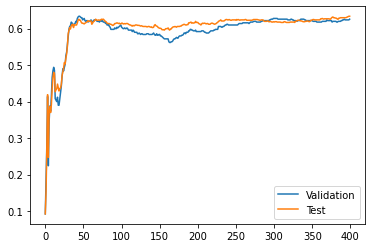

In [56]:
plt.plot(range(n_epochs), val_hist, label="Validation")
plt.plot(range(n_epochs), test_hist, label="Test")
plt.legend()

plt.show()

In [78]:
_ = train_cora(features, tf.eye(dense_adj.shape[0]), gnn, 32, 16, n_epochs, 0.01)

Epoch 0 | Training loss: 1.967482089996338 | Val accuracy: 0.10599999129772186 | Test accuracy: 0.13599997758865356
Epoch 1 | Training loss: 1.8212387561798096 | Val accuracy: 0.21199999749660492 | Test accuracy: 0.22499999403953552
Epoch 2 | Training loss: 1.6859415769577026 | Val accuracy: 0.2759999930858612 | Test accuracy: 0.27399998903274536
Epoch 3 | Training loss: 1.5226079225540161 | Val accuracy: 0.3539999723434448 | Test accuracy: 0.32199999690055847
Epoch 4 | Training loss: 1.336988925933838 | Val accuracy: 0.38599997758865356 | Test accuracy: 0.35099998116493225
Epoch 5 | Training loss: 1.1416337490081787 | Val accuracy: 0.4039999544620514 | Test accuracy: 0.38099998235702515
Epoch 6 | Training loss: 0.9469808340072632 | Val accuracy: 0.4139999747276306 | Test accuracy: 0.38999998569488525
Epoch 7 | Training loss: 0.7638827562332153 | Val accuracy: 0.4259999692440033 | Test accuracy: 0.41099992394447327
Epoch 9 | Training loss: 0.4632934331893921 | Val accuracy: 0.433999985

In [82]:
# degrees = np.sum(dense_adj, axis=1)
degrees = tf.reduce_sum(dense_adj, axis=-1)
_ = train_cora(features, dense_adj/degrees, gnn, 32, 16, n_epochs, 0.01)

Epoch 0 | Training loss: 1.9459519386291504 | Val accuracy: 0.23599998652935028 | Test accuracy: 0.2069999724626541
Epoch 1 | Training loss: 1.8307874202728271 | Val accuracy: 0.2759999930858612 | Test accuracy: 0.296999990940094
Epoch 2 | Training loss: 1.6833187341690063 | Val accuracy: 0.4039999842643738 | Test accuracy: 0.41099995374679565
Epoch 3 | Training loss: 1.5120947360992432 | Val accuracy: 0.5739999413490295 | Test accuracy: 0.5950000286102295
Epoch 4 | Training loss: 1.3289673328399658 | Val accuracy: 0.6219999194145203 | Test accuracy: 0.6579999327659607
Epoch 5 | Training loss: 1.1529216766357422 | Val accuracy: 0.6520000100135803 | Test accuracy: 0.6969999074935913
Epoch 6 | Training loss: 0.9845744371414185 | Val accuracy: 0.6639999747276306 | Test accuracy: 0.7139999866485596
Epoch 7 | Training loss: 0.8253985047340393 | Val accuracy: 0.6999999284744263 | Test accuracy: 0.7289999127388
Epoch 8 | Training loss: 0.6834670901298523 | Val accuracy: 0.7279999256134033 | T

In [86]:
norm_deg = tf.linalg.diag(1.0/tf.sqrt(degrees))
norm_adj = tf.matmul(norm_deg, tf.matmul(dense_adj, norm_deg))
_ = train_cora(features, norm_adj, gnn, 32, 16, n_epochs, 0.01)

Epoch 0 | Training loss: 1.9443117380142212 | Val accuracy: 0.09599999338388443 | Test accuracy: 0.12599998712539673
Epoch 1 | Training loss: 1.86823308467865 | Val accuracy: 0.15600000321865082 | Test accuracy: 0.17499998211860657
Epoch 2 | Training loss: 1.7444885969161987 | Val accuracy: 0.29999998211860657 | Test accuracy: 0.351999968290329
Epoch 3 | Training loss: 1.5861327648162842 | Val accuracy: 0.37599998712539673 | Test accuracy: 0.40299999713897705
Epoch 4 | Training loss: 1.4119409322738647 | Val accuracy: 0.4179999828338623 | Test accuracy: 0.47200000286102295
Epoch 5 | Training loss: 1.2322349548339844 | Val accuracy: 0.46999990940093994 | Test accuracy: 0.5139999389648438
Epoch 6 | Training loss: 1.0562254190444946 | Val accuracy: 0.5459999442100525 | Test accuracy: 0.5699999332427979
Epoch 7 | Training loss: 0.8927748203277588 | Val accuracy: 0.5999999046325684 | Test accuracy: 0.6179999113082886
Epoch 8 | Training loss: 0.7399344444274902 | Val accuracy: 0.643999993801